In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics, model_selection, linear_model, tree, ensemble, neighbors
import pickle

%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Data preprocessing

In [3]:
# read train data
df = pd.read_csv('train.tsv',sep='\t')
libs = df.libs
df.head()

,is_virus,filename,libs
0,1,VirusShare_44a578f74f71c566b2ea3702a581bf0d,kernel32.dll
1,1,VirusShare_852c5ccb274e5cac09cbaa0bf6ee9d76,"kernel32.dll,advapi32.dll,comctl32.dll,comdlg3..."
2,1,VirusShare_d7e9e47398dd04225d21fa3afc3acc5a,"msvcrt.dll,kernel32.dll,user32.dll,advapi32.dl..."
3,1,VirusShare_04dee410f3aef6ff2fbbf58cc6a38fbf,"kernel32.dll,user32.dll,gdi32.dll,advapi32.dll..."
4,1,VirusShare_04ce876f84647d16e6ef35a6deae629f,"kernel32.dll,advapi32.dll,msvcrt.dll,user32.dl..."


In [4]:
df.shape

(16290, 3)

In [5]:
# general data information 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16290 entries, 0 to 16289
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   is_virus  16290 non-null  int64 
 1   filename  16290 non-null  object
 2   libs      16290 non-null  object
dtypes: int64(1), object(2)
memory usage: 381.9+ KB


In [6]:
# check for data gaps
df.isnull().values.any()

False

In [7]:
# convert text data to a matrix of token counts
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(','))
V = vectorizer.fit_transform(libs)

# split the data into train subsets
X_train = V.toarray()
y_train = df['is_virus'].to_numpy()

Class 1: 66.7%
Class 0: 33.3%


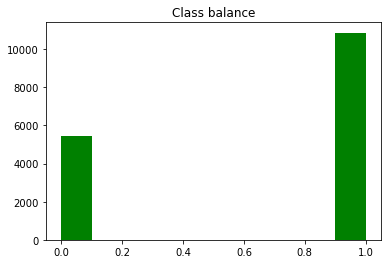

In [8]:
# check the class balance
pylab.hist(y_train, color = 'g')
pylab.title('Class balance')

print('Class 1: {:.1%}'.format(len(y_train[y_train==1])/len(y_train)))
print('Class 0: {:.1%}'.format(len(y_train[y_train==0])/len(y_train)))

### Classifiers creating

In [9]:
# the function accepts an array of classifiers as input
# returns an array of class labels probability predictions 
# and an array of class labels predictions

In [10]:
classifier_1 = linear_model.LogisticRegression().fit(X_train,y_train)
classifier_2 = tree.DecisionTreeClassifier().fit(X_train,y_train)
classifier_3 = neighbors.KNeighborsClassifier().fit(X_train,y_train)
classifier_4 = linear_model.SGDClassifier(loss='log').fit(X_train,y_train)

classifiers = [classifier_1,classifier_2,classifier_3,classifier_4]
description = ['Logistic Regression Classifier','Decision Tree Classifier','KNeighbours Classifier','SGD Classifier']

C:\Users\user\anaconda3\envs\p38\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [11]:
p_predict = []
predict = []
for classifier in classifiers:
    p_predicted = classifier.predict_proba(X_train)
    p_predict.append(p_predicted)
    predicted = classifier.predict(X_train)
    predict.append(predicted)

### Classifiers compare

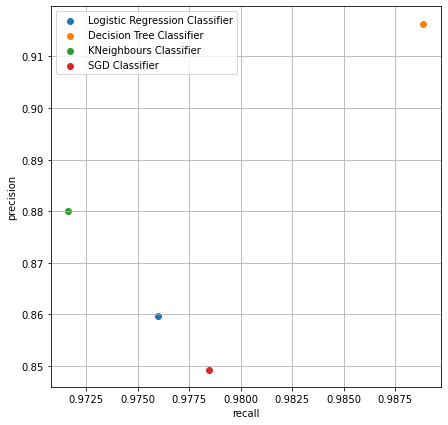

In [12]:
# calculate precision, recall and f-metric
# plot the dots in the precision-recall axises

plt.figure(figsize=(7, 7))
pyplot.grid()

precisions = []
recalls = []
f_scores = []

for predicted in predict:
    f_score = metrics.f1_score(y_train,predicted)
    f_scores.append(f_score)
    precision = metrics.precision_score(y_train, predicted)
    recall = metrics.recall_score(y_train, predicted)
    precisions.append(precision)
    recalls.append(recall)
    
for precision, recall, descr in zip(precisions,recalls,description):
     pylab.scatter(recall, precision, label=descr)
    
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="upper left")

Text(0.5, 1.0, 'PR curves')

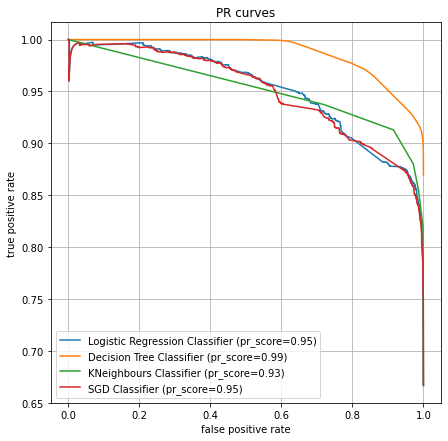

In [13]:
# plot the precision-recall curve given the classifiers and training data
# calculate pr-scores for the classifiers

plt.figure(figsize=(7, 7))
pyplot.grid()

for p_predicted, descr in zip(p_predict,description):
    pr, rec, thr = metrics.precision_recall_curve(y_train, p_predicted[:,1])
    pr_score = metrics.average_precision_score(y_train, p_predicted[:,1])
    pylab.plot(rec,pr, label=descr + ' (pr_score={:.2f})'.format(pr_score))
    
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="lower left")
plt.title('PR curves')

Text(0.5, 1.0, 'ROC curves')

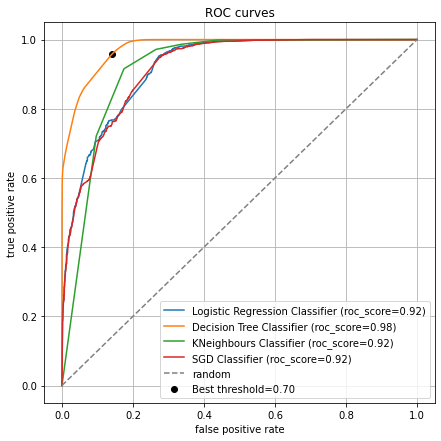

In [14]:
# plot the roc curve given the classifiers and training data
# calculate roc-scores for the classifiers

plt.figure(figsize=(7, 7))
pyplot.grid()

roc_scores = []
for p_predicted,descr in zip(p_predict,description):
    fpr, tpr, thr = metrics.roc_curve(y_train, p_predicted[:,1])
    roc_score = metrics.roc_auc_score(y_train, p_predicted[:,1])
    roc_scores.append(roc_score)
    pylab.plot(fpr, tpr, label=descr + ' (roc_score={:.2f})'.format(roc_score))

    
# mark the best threshold on the best classifier plot

idx = argmax(roc_scores)
fpr, tpr, thr = metrics.roc_curve(y_train, p_predict[idx][:,1])
gmeans = sqrt(tpr * (1-fpr))
ix = argmax(gmeans)
best_thr = thr[ix]
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black',label='Best threshold={:.2f}'.format(thr[ix]))
    
pylab.plot([0, 1], [0, 1], '--', color = 'grey', label = 'random')
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="lower right")
plt.title('ROC curves')

In [15]:
# save the best threshold as a file
with open('threshold.txt','w') as file:
    file.write(str(best_thr))

In [18]:
# save classifier with the highest f-score as a pickle string
idx = np.argmax(f_scores)
best_classifier = classifiers[idx]
print('Best classifier is the',description[idx])
pickle.dump(best_classifier, open('Classifier.joblib', 'wb'))

Best classifier is the Decision Tree Classifier
